In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dist_ir.ir import Module
from dist_ir.ir import Topology
from dist_ir.ir.type import Float
from dist_ir.ir.type import Tensor
from dist_ir.executor.cost_inference import CostModel
from dist_ir.executor import DistributedSimulator
from dist_ir.transforms import DataParallelTransform

In [3]:
def construct_topology(num_devices, bandwidth):
    topology = Topology()
    for i in range(num_devices):
        topology.add_device("gpu")
    for i in range(num_devices):
        for j in range(i + 1, num_devices):
            topology.set_bandwidth(topology.devices[i], topology.devices[j], bandwidth)
    return topology

In [4]:
def construct_mlp_module(topology, batch_size, num_classes, input_dim, hidden_dims):
    module = Module()

    device = topology.devices[0]
    x = module.add_input_value(
        "x", Tensor(Float(), (batch_size, input_dim), device=device)
    )
    z = module.add_input_value(
        "z", Tensor(Float(), (batch_size, num_classes), device=device)
    )

    weights = []
    weight_grads = []
    activations = []
    activation_grads = []

    for i in range(0, len(hidden_dims) + 1):
        if i == 0:
            dims = (input_dim, hidden_dims[0])
        elif i == len(hidden_dims):
            dims = (hidden_dims[-1], num_classes)
        else:
            dims = (hidden_dims[i - 1], hidden_dims[i])
        weights.append(
            module.add_input_value(
                f"w{i}",
                Tensor(Float(), dims, device=device),
            )
        )

    for i in range(0, len(weights) - 1):
        if i == 0:
            inputs = [x, weights[0]]
        else:
            inputs = [activations[i - 1], weights[i]]
        activations.append(
            module.add_op(
                "MatMul",
                f"MatMul{i}",
                inputs=inputs,
                output_names=[f"a{i}"],
            )
        )
    y = module.add_op(
        "MatMul",
        f"MatMul{i+1}",
        inputs=[activations[-1], weights[-1]],
        output_names=["y"],
    )
    l = module.add_op(
        "Loss", "Loss", inputs=[y, z], attributes={"N": batch_size}, output_names=["l"]
    )
    dl = module.add_op(
        "LossGrad",
        "LossGrad",
        inputs=[y, z],
        attributes={"N": batch_size},
        output_names=["dl"],
    )

    backprop = dl
    for i in range(len(weights) - 1, -1, -1):
        if i > 0:
            a = activations[i - 1]
        else:
            a = x
        w = weights[i]
        da, dw = module.add_op(
            "MatMulGrad",
            f"MatMul{i}Grad",
            inputs=[a, w, backprop],
            output_names=[f"d{a.name}", f"d{w.name}"],
        )
        activation_grads.append(da)
        weight_grads.append(dw)
        backprop = da

    module.set_outputs(weight_grads)
    module.finalize()
    return module

In [5]:
def simulate_data_parallel(
    num_workers,
    batch_size=16,
    input_dim=4,
    hidden_dims=[2],
    num_classes=10,
    bandwidth=2,
    device_speeds={"gpu": 1.0e13}
):
    topology = construct_topology(num_workers, bandwidth)
    module = construct_mlp_module(
        topology, batch_size, num_classes, input_dim, hidden_dims
    )
    transform = DataParallelTransform(
        batch_dims={"x": 0, "z": 0},
        reduction_params={
            f"{dw.name}": {"op_type": "Allreduce"} for dw in module.get_outputs()
        },
        devices=topology.devices,
    )
    transformed_module = transform.apply(module)
    transformed_module.finalize()
    cost_model = CostModel(topology, device_speeds)
    simulator = DistributedSimulator(cost_model)
    simulator_state = simulator.simulate(transformed_module)
    execution_time = max(
        [simulator_state.timestamps[device] for device in topology.devices]
    )
    return execution_time

In [6]:
def run_data_parallel_experiment(
    all_num_workers,
    batch_size,
    input_dim,
    hidden_dims,
    num_classes,
    bandwidth,
    device_speeds,
):
    all_execution_times = []
    for num_workers in all_num_workers:
        all_execution_times.append(
            simulate_data_parallel(
                num_workers,
                batch_size,
                input_dim,
                hidden_dims,
                num_classes,
                bandwidth,
                device_speeds,
            )
        )
    return all_execution_times

In [7]:
def get_data_parallel_data(all_num_workers, all_batch_sizes):
    input_dim = 32
    hidden_dims = [64, 128, 256, 512, 1024]
    num_classes = 10
    bandwidth = 100.0
    device_speeds = {"gpu": 1.0e13}
    results = {
        batch_size: run_data_parallel_experiment(
            all_num_workers,
            batch_size,
            input_dim,
            hidden_dims,
            num_classes,
            bandwidth,
            device_speeds,
        )
        for batch_size in all_batch_sizes
    }
    return results

In [8]:
def plot_data_parallel_results(all_num_workers, all_batch_sizes, results):
    frame = plt.gca()
    for batch_size in all_batch_sizes:
        plt.plot(
            all_num_workers,
            results[batch_size],
            marker="o",
            label=f"Batch size {batch_size}",
        )
    plt.legend()
    plt.xlabel("# Workers\n(log scale)")
    plt.ylabel("Execution time")
    plt.xscale("log")
    _ = plt.xticks(all_num_workers)
    _ = frame.axes.xaxis.set_ticklabels(all_num_workers)
    _ = frame.axes.yaxis.set_ticklabels([])
    plt.tight_layout()
    plt.savefig("figures/data_parallel_results.png", dpi=300)

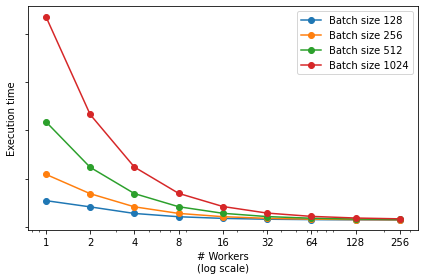

In [9]:
all_num_workers = [1, 2, 4, 8, 16, 32, 64, 128, 256]
all_batch_sizes = [128, 256, 512, 1024]
data_parallel_results = get_data_parallel_data(all_num_workers, all_batch_sizes)
plot_data_parallel_results(all_num_workers, all_batch_sizes, data_parallel_results)